<a href="https://colab.research.google.com/github/anishantony8/Vehicle_Classifier/blob/main/Vehicle_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
import tensorflow as tf
import os
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
import splitfolders
import pathlib
import tensorflow_hub as hub

In [44]:
base_ds = '/content/data/vehicle'
base_ds = pathlib.Path(base_ds)

In [45]:
splitfolders.ratio(base_ds,output='imgs',seed=123,ratio=(.7,.2,.1),group_prefix=None)

Copying files: 449 files [00:00, 2395.13 files/s]


In [52]:
data_dir = '/content/imgs/train'

In [49]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [53]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            

In [54]:
data_dir = '/content/imgs/test'
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))

In [55]:
data_dir = '/content/imgs/val'
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))

In [3]:
!mkdir data

In [4]:
!unzip /content/vehicle.zip -d /content/data

Archive:  /content/vehicle.zip
   creating: /content/data/vehicle/bike/
  inflating: /content/data/vehicle/bike/05performance-bikes-2018-1.jpg  
  inflating: /content/data/vehicle/bike/10-bikes-instead-of-iPhone-14-pro-max.jpg  
  inflating: /content/data/vehicle/bike/1683132774893  
  inflating: /content/data/vehicle/bike/192px.svg  
  inflating: /content/data/vehicle/bike/2023-ducati-diavel-v4.jpg  
  inflating: /content/data/vehicle/bike/23-rzxr-action-65.jpg  
  inflating: /content/data/vehicle/bike/250cc-bikes-in-India-1.jpg  
  inflating: /content/data/vehicle/bike/2bd5ab426e192ba524bc5c49d0930236a632e.jpeg  
  inflating: /content/data/vehicle/bike/38013-vulcan-s.jpg  
  inflating: /content/data/vehicle/bike/4a2qrcio_bike_625x300_07_March_22.jpg  
  inflating: /content/data/vehicle/bike/61GSDG7MDBL._SY355_.jpg  
  inflating: /content/data/vehicle/bike/71GYgK7VIRL._SY450_.jpg  
  inflating: /content/data/vehicle/bike/90500224.jpg  
  inflating: /content/data/vehicle/bike/98766661.

In [74]:
batch_size = 128
img_height = 224
img_width = 224     

In [75]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory('/content/imgs/train',
  seed=111,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 313 files belonging to 3 classes.


In [76]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory('/content/imgs/test',
  seed=111,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 47 files belonging to 3 classes.


In [77]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory('/content/imgs/val',
  seed=111,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 88 files belonging to 3 classes.


In [78]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(128, 224, 224, 3)
(128,)


In [79]:
classes=train_ds.class_names
print(classes)

['bike', 'bus', 'car']


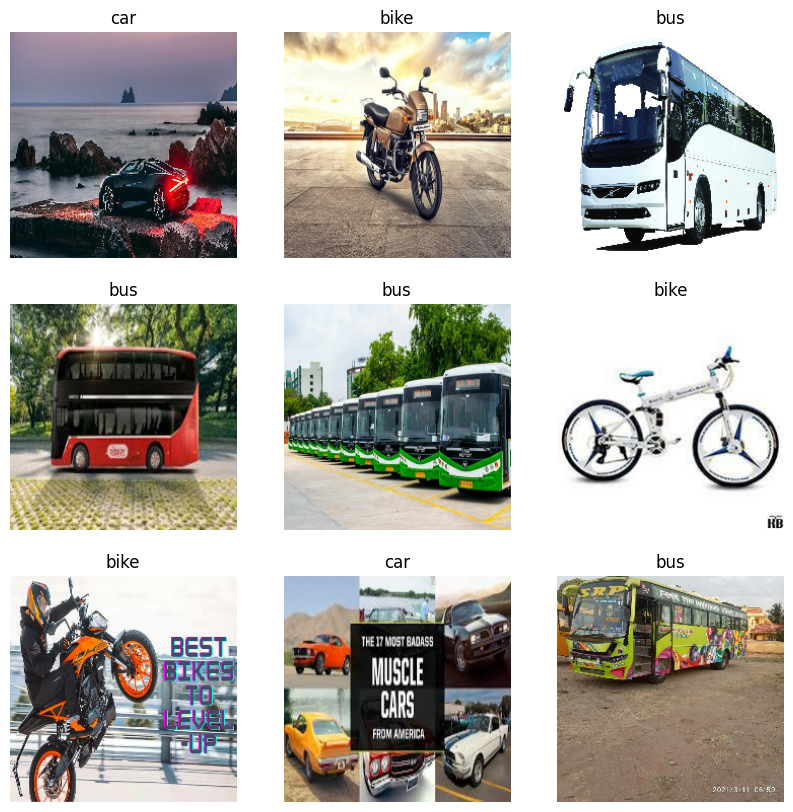

In [80]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classes[labels[i]])
    plt.axis("off")

In [81]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [82]:
feature_extractor = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

In [83]:
feature_extractor_layer = hub.KerasLayer(feature_extractor, input_shape=(img_height,img_width,3))

In [84]:
feature_extractor_layer.trainable = False

In [85]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [86]:
tf.random.set_seed(111)

In [87]:
model = tf.keras.Sequential([
  normalization_layer,
  feature_extractor_layer,
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(3,activation='softmax')
])

In [88]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [89]:
history = model.fit(train_ds, epochs=20, validation_data=val_ds)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


3/3 [==============================] - 26s 6s/step - loss: 1.3387 - accuracy: 0.4089 - val_loss: 0.8880 - val_accuracy: 0.5909
Epoch 2/20
3/3 [==============================] - 18s 7s/step - loss: 0.8999 - accuracy: 0.5687 - val_loss: 0.6088 - val_accuracy: 0.7727
Epoch 3/20
3/3 [==============================] - 16s 5s/step - loss: 0.6156 - accuracy: 0.7764 - val_loss: 0.4085 - val_accuracy: 0.8977
Epoch 4/20
3/3 [==============================] - 17s 6s/step - loss: 0.4312 - accuracy: 0.8626 - val_loss: 0.2853 - val_accuracy: 0.9773
Epoch 5/20
3/3 [==============================] - 18s 6s/step - loss: 0.3509 - accuracy: 0.9042 - val_loss: 0.2147 - val_accuracy: 0.9773
Epoch 6/20
3/3 [==============================] - 18s 6s/step - loss: 0.2581 - accuracy: 0.9233 - val_loss: 0.1716 - val_accuracy: 0.9773
Epoch 7/20
3/3 [==============================] - 17s 6s/step - loss: 0.1626 - accuracy: 0.9712 - val_loss: 0.1444 - val_accuracy: 0.9773
Epoch 8/20
3/3 [=============================

In [90]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_3 (Dense)             (None, 3)                 3843      
                                                                 
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


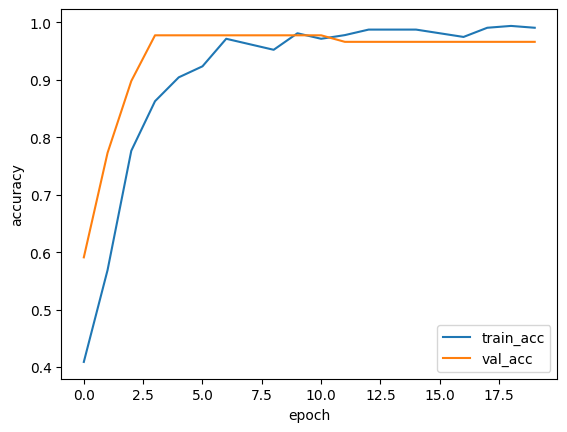

In [91]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='best')
plt.show()

In [92]:
result=model.evaluate(test_ds)

1/1 [==============================] - 3s 3s/step - loss: 0.1500 - accuracy: 0.9574


1/1 [==============================] - 0s 52ms/step


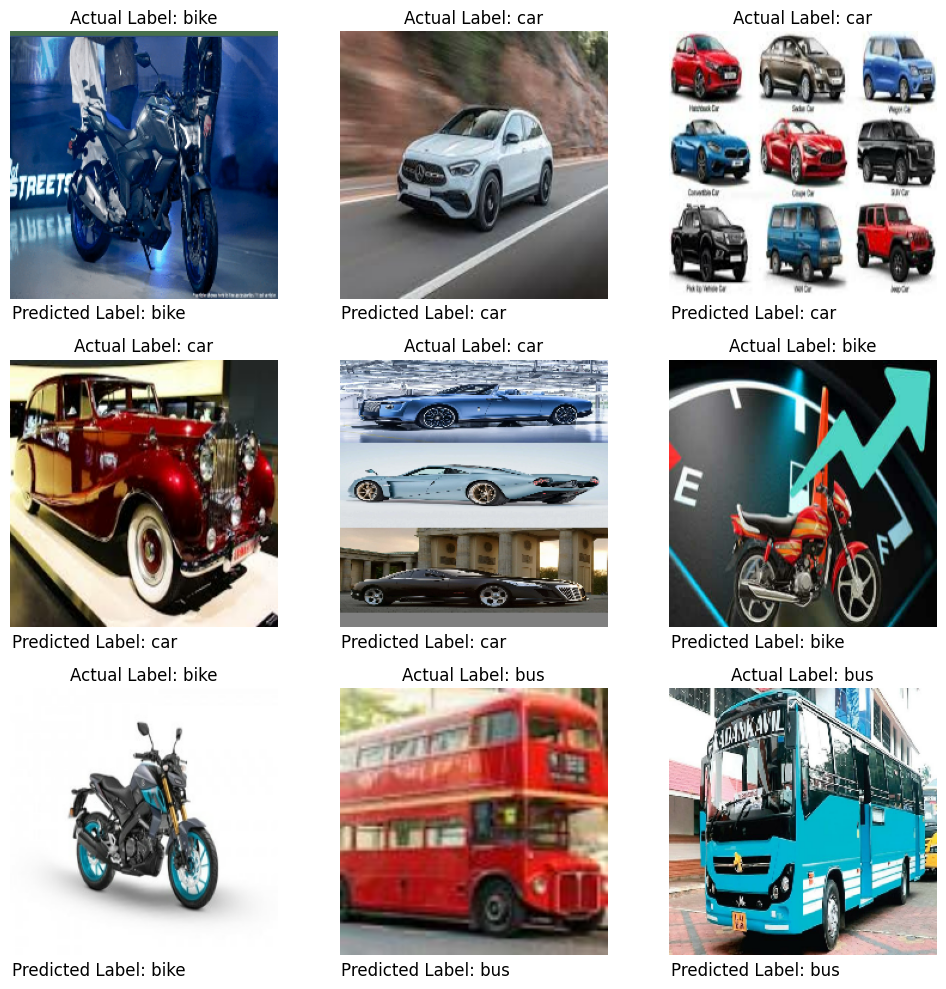

In [93]:
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)

    plt.tight_layout()
    
    img = tf.keras.preprocessing.image.img_to_array(images[i])                    
    img = np.expand_dims(img, axis=0)  

    pred=model.predict(img)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title("Actual Label: %s" % classes[labels[i]])
    plt.text(1, 240, "Predicted Label: %s" % classes[np.argmax(pred)], fontsize=12)

    plt.axis("off")

In [94]:
model.save('./models', save_format='tf')

In [95]:
!ls -alrt models

total 2096
drwxr-xr-x 1 root root    4096 May  3 18:35 ..
drwxr-xr-x 2 root root    4096 May  3 18:35 variables
drwxr-xr-x 2 root root    4096 May  3 18:35 assets
-rw-r--r-- 1 root root      56 May  3 18:35 fingerprint.pb
-rw-r--r-- 1 root root 2115456 May  3 18:35 saved_model.pb
-rw-r--r-- 1 root root    7645 May  3 18:35 keras_metadata.pb
drwxr-xr-x 4 root root    4096 May  3 18:35 .


In [96]:
model_loaded = tf.keras.models.load_model('./models/')

In [97]:
model.save(os.path.join('output','vehicleclassifier.h5'))

In [98]:
!zip -r models.zip models/

  adding: models/ (stored 0%)
  adding: models/variables/ (stored 0%)
  adding: models/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: models/variables/variables.index (deflated 78%)
  adding: models/saved_model.pb (deflated 91%)
  adding: models/assets/ (stored 0%)
  adding: models/fingerprint.pb (stored 0%)
  adding: models/keras_metadata.pb (deflated 82%)
